# HK Data Jobs Analysis

A lot of the code here is referenced from: https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial

In [1]:
import csv
import os
import re
import string
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from langdetect import detect
import matplotlib.pyplot as plt
import math
import statistics as stats
from wordcloud import WordCloud
from mlxtend.frequent_patterns import fpgrowth
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from snorkel.labeling import labeling_function

## run once
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Data

In [2]:
DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)
pd.set_option('display.max_rows', 50)

In [3]:
df = pd.read_csv('../airflow/data/staging/result_big_table/result.csv',
                 sep='\\t',
                 header=None,
                 engine='python',
                 names=['job_id', 'job_title', 'company_name', 
                        'job_description', 'location', 'official_post_date',
                        'min_official_salary', 'max_official_salary', 'career_level',
                        'qualification', 'job_type', 'job_functions', 'industry',
                        'min_salary', 'max_salary']
                )
df.drop_duplicates(subset=['job_description', 'job_title', 'company_name'], keep='last', inplace=True)

# formatting
df['job_description'] = df['job_description'].astype(str)
df = df.replace(r'\\n+|\\t+\\r+',' ', regex=True)
df['mid_salary'] = ((df['min_salary'] + df['max_salary']) / 2).astype(int)

#### Label Agency Jobs

In [4]:
agency_df = pd.read_csv('agency_list.csv')

agency_names = agency_df[agency_df.is_agency == True].company_name
non_agency_names = agency_df[agency_df.is_agency == False].company_name

def label_agency(job_description, company_name):
    if company_name in non_agency_names:
        return False
    elif company_name in agency_names:
        return True
    elif re.search(r"\bmy client[^'s]", job_description, flags=re.I):
        return True
    elif re.search(r"\bour client[^'s]", job_description, flags=re.I):
        return True
    else:
        return False
    
df['agency'] = df.apply(lambda x: label_agency(x['job_description'], x['company_name']), axis=1)

#### Filter to data-related jobs only

In [5]:
df = df[df.job_title.str.contains(r'Data|Machine Learning|Business Intelligence|Analytics|Computer Vision|Deep Learning', 
                                               flags=re.IGNORECASE, regex=True)|
        df.job_title.str.contains(r'\b(AI|BI|ML|MLE|ETL|SQL|NLP)\b', 
                                            regex=True)]

# remove jobs that are related to data CENTER/ENTRY, instead of data
df = df[~df.job_title.str.contains(r'(data center|data centre|data entry|data translator|translation|data-entry)', flags=re.IGNORECASE, regex=True)]

C:\Users\admin\AppData\Local\Temp\ipykernel_6980\424090319.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.job_title.str.contains(r'\b(AI|BI|ML|MLE|ETL|SQL|NLP)\b',
C:\Users\admin\AppData\Local\Temp\ipykernel_6980\424090319.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df.job_title.str.contains(r'(data center|data centre|data entry|data translator|translation|data-entry)', flags=re.IGNORECASE, regex=True)]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 61 to 46800
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               2397 non-null   int64  
 1   job_title            2397 non-null   object 
 2   company_name         2397 non-null   object 
 3   job_description      2397 non-null   object 
 4   location             1633 non-null   object 
 5   official_post_date   2397 non-null   object 
 6   min_official_salary  241 non-null    float64
 7   max_official_salary  239 non-null    float64
 8   career_level         1565 non-null   object 
 9   qualification        1829 non-null   object 
 10  job_type             2397 non-null   object 
 11  job_functions        2397 non-null   object 
 12  industry             2375 non-null   object 
 13  min_salary           2397 non-null   int64  
 14  max_salary           2397 non-null   int64  
 15  mid_salary           2397 non-null  

# Prepare for Kmeans clustering
Use TFIDF to convert words to features and use Kmeans to separate into clusters

#### Pre-processing for text feature - tokenization and stop words

In [7]:
class LemmaTokenizer(object):

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        lemmas = []
        
        # Pre-proccessing of one document at the time
        
        # Removing puntuation
        translator_1 = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        document = document.translate(translator_1)

        # Removing numbers
        document = re.sub(r'\d+', ' ', document)

        # Removing special characters
        document = re.sub(r"[^a-zA-Z0-9]+", ' ', document)

        # The document is a string up to now, after word_tokenize(document) we'll work on every word one at the time
        for token in word_tokenize(document):
            
            # Removing spaces
            token = token.strip()
            
            # Lemmatizing
            token = self.lemmatizer.lemmatize(token)

            # Removing stopwords
            if token not in stopwords and len(token) > 2:
                lemmas.append(token)
        return lemmas


def custom_import_stopwords(filename):
    in_stopword_list = []
    in_flag = 0
    in_word_cnt = 0

    with open(filename, encoding="utf8") as f:
        for row in csv.reader(f):
            if in_flag == 0:
                in_flag = 1
            else:
                in_stopword_list.append(row[0])
                in_word_cnt += 1

    print(f"{in_word_cnt} stopwords imported")
    return in_stopword_list

#### Use TFIDF to convert words to features

We use both the job title and job description.

In [8]:
stopwords = custom_import_stopwords('english_stopwords.csv')

# Custom tokenizer for tfidf representation
vectorizer = TfidfVectorizer(input='content', tokenizer=LemmaTokenizer(), ngram_range=(1, 2))

# Here we need the correct path in order to give it to the vectorizer
print("Generating TFIDF sparse matrix...")
X = (df['job_description'] + ' ' + df['job_title']).values
X_tfidf = vectorizer.fit_transform(X)

783 stopwords imported
Generating TFIDF sparse matrix...


#### Use PCA to reduce dimension

In [9]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=128, random_state=42, n_iter=5)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.26


#### Run Kmeans on different k and check silhouette score

In [10]:
def generate_wordclouds(X, in_X_tfidf, k, in_word_positions, only_clustering=False):

    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    if only_clustering:
        return
    
    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_y_pred

# Trials, uncomment the line to start clustering but mind the parameter for the number of clusters
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
for i in range(2, 20):
    generate_wordclouds(X_svd, X_tfidf, i, word_positions, only_clustering=True)

For n_clusters = 2 The average silhouette_score is : 0.34708532140547943
For n_clusters = 3 The average silhouette_score is : 0.12155934000338862
For n_clusters = 4 The average silhouette_score is : 0.14287405153890492
For n_clusters = 5 The average silhouette_score is : 0.06427401514228581
For n_clusters = 6 The average silhouette_score is : 0.03208192400578838
For n_clusters = 7 The average silhouette_score is : 0.07204150878471588
For n_clusters = 8 The average silhouette_score is : 0.07603072198940321
For n_clusters = 9 The average silhouette_score is : 0.042116637848963384
For n_clusters = 10 The average silhouette_score is : 0.07700659947413546
For n_clusters = 11 The average silhouette_score is : 0.08513557317040679
For n_clusters = 12 The average silhouette_score is : 0.07796447888844445
For n_clusters = 13 The average silhouette_score is : 0.0595265135118304
For n_clusters = 14 The average silhouette_score is : 0.0818703406180678
For n_clusters = 15 The average silhouette_scor

#### Run K means and visualize with word clouds

For n_clusters = 3 The average silhouette_score is : 0.12155934000338862


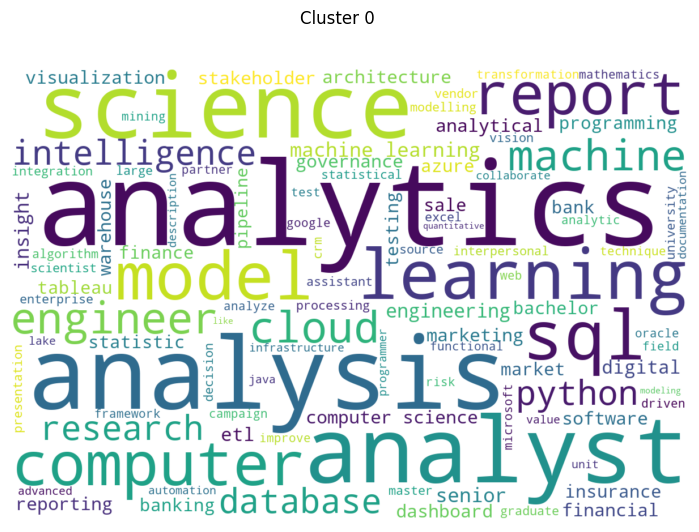

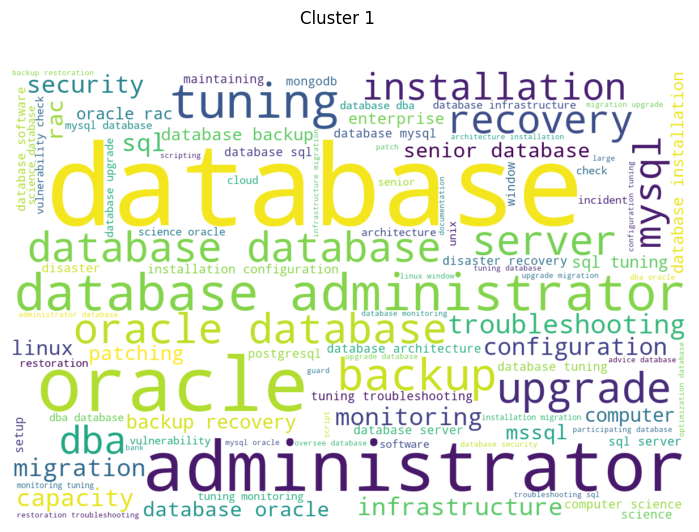

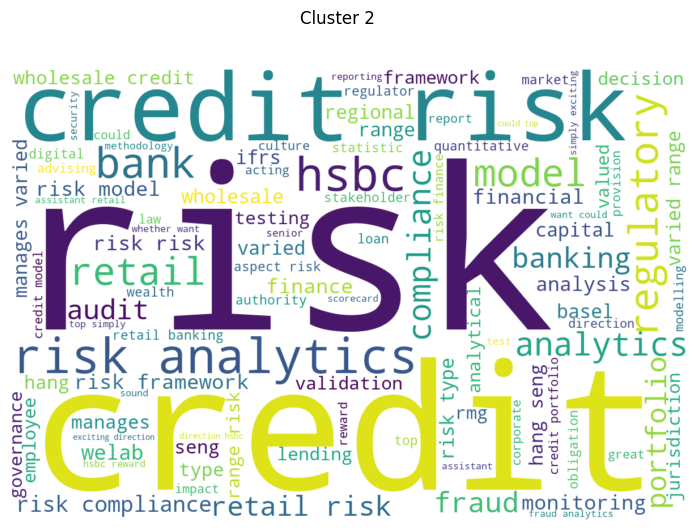

In [11]:
import warnings
warnings.filterwarnings('ignore')

cluster_index = generate_wordclouds(X_svd, X_tfidf, 3, word_positions)

# Interpreting Kmeans

It seems that K means has formed these clusters for us:
- Cluster 0: Data Analyst/Scientist/Engineers
- Cluster 1: Older sysadmin-related, IT-related Database Administrator jobs
- Cluster 2: Banking related/risk analytics jobs that require strong domain knowledge in finance

I was hoping that it would separate more finely the jobs Data Analyst / Data Scientist / Data Engineer / Machine Learning Engineer etc. But further clustering did not really seem to help - a possible reason is that the job duties of them largely overlap.

Either way, we managed to filter out jobs that were unrelated, namely cluster 1 and cluster 2.

In [12]:
df['cluster'] = cluster_index

### Create master table for data related jobs

We take all the jobs from the chosen cluster - assuming that Kmeans have helped us group all the data-related jobs into the same cluster. We then also concatenate jobs from other clusters - jobs that specifically are titled with data-related keywords.

In [13]:
# data cluster + jobs from other clusters that have related titles, e.g. "data analyst"
chosen_cluster_df = df[(df.cluster != 1) & (df.cluster != 2)]

# drop ununsed columns
master_df = chosen_cluster_df.drop(columns=['job_id', 'min_official_salary', 'max_official_salary', 'job_type', 'job_functions', 'cluster'])

#### Fill in NaN values

In [14]:
print(master_df.isna().sum())

master_df['location'] = master_df['location'].fillna('')
master_df['career_level'] = master_df['career_level'].fillna('')
master_df['qualification'] = master_df['qualification'].fillna('')
master_df['industry'] = master_df['industry'].fillna('')

job_title               0
company_name            0
job_description         0
location              696
official_post_date      0
career_level          751
qualification         520
industry               20
min_salary              0
max_salary              0
mid_salary              0
agency                  0
dtype: int64


#### Remove bad faith data

There are entries that have set the salary to have an unreasonable range - meaning it's put in bad faith.

In [15]:
master_df = master_df[(master_df.max_salary - master_df.min_salary <= 60000)]

#### Remove agency listings

In [16]:
# master_df = master_df[master_df.agency == False]

# EDA

Since kmeans wasn't able to help us separate jobs more precisely, we will categorize them by hand based on their job titles and using RegEx.

#### Categorize job postings roughly by hand

In [17]:
def job_category(job_title):
    if re.search(r"Data[\s&\w]*Analyst", job_title, re.IGNORECASE):
        return 'DA'
    if re.search(r"Data Engineer|Data Migration Engineer", job_title, re.IGNORECASE):
        return 'DE'
    if re.search(r"Data Scientist|Data Science|AI", job_title, re.IGNORECASE):
        return 'DS'
    if re.search(r"Machine Learning Engineer|Machine Learning|MLops", job_title, re.IGNORECASE):
        return 'MLE'
    if re.search(r"Business Intelligence|BI Data Senior Engineer", job_title, re.IGNORECASE):
        return 'BI Dev'
    if re.search(r"\b(BI|ETL|SQL)\b", job_title):
        return 'BI Dev'
    if re.search(r"Specialist", job_title, re.IGNORECASE):
        return "Specialist"
    if re.search(r"Computer Vision|NLP|Deep Learning|Research", job_title, re.IGNORECASE):
        return 'ML Research'
    if re.search(r"Business Analyst|Business Analytics", job_title, re.IGNORECASE):
        return 'BA'
    if re.search(r"Privacy|Steward|Governance|Data Quality|Data Management|Data Manager|Model|Modeling|Modelling", job_title, re.IGNORECASE):
        return 'Data Governance'
    if re.search(r"Data Architect", job_title, re.IGNORECASE):
        return 'Data Architect'
    if re.search(r"Software Engineer|Programmer|Developer|System Analyst|Systems Analyst|Data Integration", job_title, re.IGNORECASE):
        return "DE"
    if re.search(r"Lead|Manager|Director|Leader|Head|VP|Vice President|Evangelist|Principal", job_title, re.IGNORECASE):
        return "Management"
    if re.search(r"Market|Marketing|CRM|Digital", job_title, re.IGNORECASE):
        return "Marketing DA"
    if re.search(r"Analytics|Analysis", job_title, re.IGNORECASE):
        return 'DA'
    else:
        return 'Others'

master_df['category'] = [job_category(title) for title in master_df['job_title']]
print(master_df["category"].value_counts())

DA                 527
DS                 318
DE                 249
Management         225
BI Dev             199
Data Governance    105
Others              95
BA                  56
Specialist          47
MLE                 43
ML Research         42
Marketing DA        26
Data Architect      16
Name: category, dtype: int64


In [18]:
master_df[master_df.category == 'Management'].sample(50)

,job_title,company_name,job_description,location,official_post_date,career_level,qualification,industry,min_salary,max_salary,mid_salary,agency,category
29260,Data Analytics Manager,Conners Consulting Limited,Our client is a well-known and fast expanding ...,,2022-09-30,Middle,Degree,Human Resources Management/Consultancy,30000,60000,45000,True,Management
36237,Data Analytics Manager (Bank),KOS International Limited,Data Analytics Manager (Banking) Business anal...,,2022-08-05,Middle,Degree,Human Resources Management/Consultancy,20000,60000,40000,True,Management
45490,Manager / Senior Associate / Associate (IT Aud...,BDO,Responsibilities: Assist in planning and scopi...,Sheung Wan,2022-08-26,,Degree,Accounting/Audit/Tax Services,15000,60000,37500,False,Management
40986,"Manager, Data Platform & Visualization",Kerry Properties Limited,"We are looking for a Manager, Data Platform in...",Quarry Bay,2022-08-16,Middle,Degree,Property Management / Consultancy,11000,15000,13000,False,Management
31381,"Business Strategy & Analytics Manager, Asia So...",Ralph Lauren,Position Overview The Business Strategy & Ana...,Lai Chi Kok,2022-08-02,Middle,Degree,Clothing/Garment/Textile,30000,80000,55000,False,Management
25206,Assistant Data Analytics Manager up to 50K,Change Group Hong Kong Limited,Assistant Data Analytics Manager up to 50K Ou...,Central & Western Area,2022-09-22,,,Human Resources Management/Consultancy,15000,40000,27500,True,Management
13448,"Senior Manager, Supply Analytics (Bangkok base...",Agoda International (Hong Kong) Limited,About Agoda Agoda is an online travel booking ...,,2022-07-13,,,Tourism / Travel Agency,11000,15000,13000,False,Management
23271,"Strategy, Analytics and Customer Experience Ma...",Novartis Pharmaceuticals (HK) Ltd,Job Responsibilities Strategic planning : Supp...,Kwun Tong Area,2022-09-16,Senior,Degree,Medical/Pharmaceutical,11000,30000,20500,False,Management
36114,Senior Network Engineer - Global MNC - Data Se...,Wellesley Associates Limited,Background: My client is one of the well-reco...,,2022-08-05,,,Human Resources Management/Consultancy,20000,60000,40000,True,Management
41045,"Associate Manager, Performance & Data (Adverti...",PHD Limited,Job Description Oversee & manage on-going paid...,Pok Fu Lam,2022-08-16,Middle,Degree,Advertising/Public Relations/Marketing Services,15000,30000,22500,False,Management


In [40]:
pivot = master_df[(master_df.category != 'Others') & (master_df.career_level != '')].drop(columns=['agency', 'mid_salary']).groupby(by=["career_level", "category"]).mean().astype(int)

pivot.style.background_gradient(axis=0)

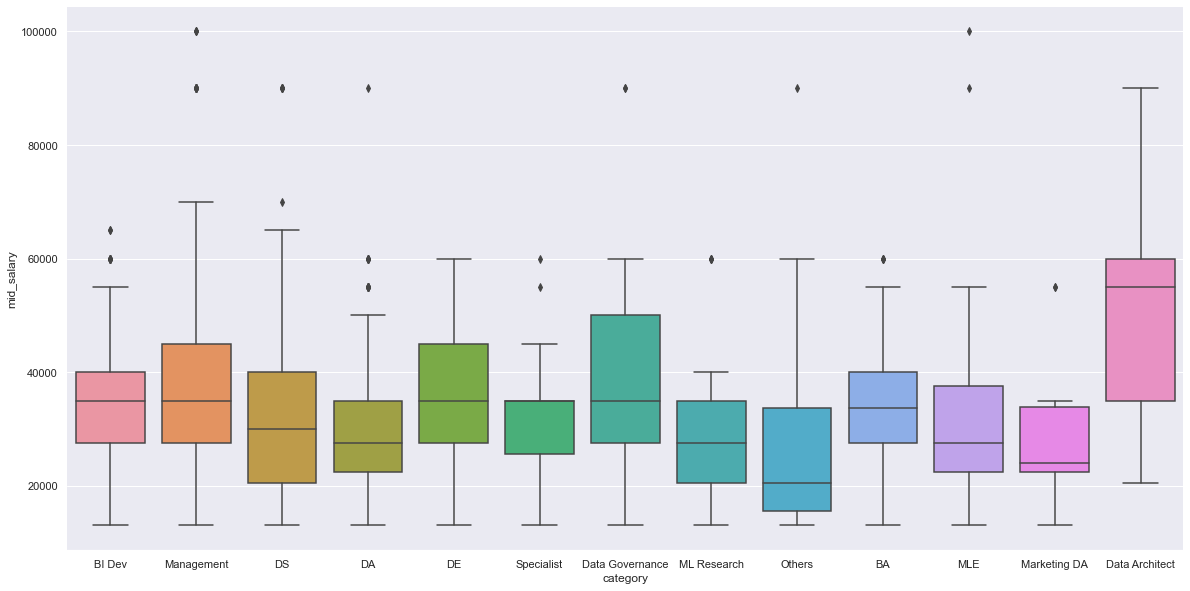

In [20]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})
sns.boxplot(data=master_df, x="category", y="mid_salary")
sns.despine(left=True)

## Explore relationship between skills and salary

In [21]:
skills = ['google cloud', 'aws', 'azure',
         'bigquery', 'redshift', 'databricks', 'snowflake',
         'airflow', 'dbt', 'prefect', 'dagster', 'airbyte',
         'spark', 'flink', 'kafka', 'hadoop',
         'etl', 'elt',
         'data governance', '(modeling|modelling)', 'star schema',
         'oracle', 'sas', 'sap',
         'python', 'sql', 'pl/sql', 't-sql', ' r ',
         'tensorflow', 'deep learning', 'sklearn', 'scikit']

dictionary = {}

skills_df = pd.DataFrame(skills, columns=['skill'])
skills_df['job_count'] = skills_df['skill'].map(lambda x: master_df[master_df.job_description.str.contains(x, case=False)].job_title.count())
skills_df['mid_salary'] = skills_df['skill'].map(lambda x: master_df[master_df.job_description.str.contains(x, case=False)].mid_salary.mean())
skills_df.style.background_gradient(axis=0)  

,skill,job_count,mid_salary
0,google cloud,45,33822.222222
1,aws,240,34500.000000
2,azure,239,36554.393305
3,bigquery,25,26780.000000
4,redshift,27,30148.148148
5,databricks,42,34309.523810
6,snowflake,12,42583.333333
7,airflow,33,37303.030303
8,dbt,6,41666.666667
9,prefect,1,20500.000000


In [22]:
location_df = master_df[['min_salary', 'max_salary', 'location']].groupby(by='location').mean()
location_df.style.background_gradient(axis=0)  

,min_salary,max_salary
location,,
,20208.955224,51127.694859
Aberdeen,20550.000000,51500.000000
Admiralty,16652.173913,41739.130435
Airport Area,13545.454545,38181.818182
Causeway Bay,19170.212766,43829.787234
Central,19081.395349,48081.395349
Central & Western Area,23796.875000,52187.500000
Cheung Sha Wan,15888.888889,37777.777778
Eastern Area,16166.666667,46666.666667


# Train Prediction Model

In [23]:
# Order by date
master_df["official_post_date"] = pd.to_datetime(master_df["official_post_date"])
master_df = master_df.sort_values("official_post_date").reset_index(drop=True)

#### Add categorical variables as label encoded values

In [24]:
categorical_features = ['location','career_level','qualification', 'industry', 'category'] 

In [25]:
encoder = preprocessing.LabelEncoder()
for f in categorical_features:
    encoder.fit(master_df[f])
    encoded = encoder.transform(master_df[f])
    master_df[f] = encoded

**Add text variables as tfidf values**

In [26]:
from sklearn.decomposition import TruncatedSVD

text_features = ["company_name", "job_title", "job_description"]

stopwords = custom_import_stopwords('english_stopwords.csv')


text_vectors = []

pca_comps = {
    "company_name": 256,
    "job_title": 512,
    "job_description": 1024,
} 

for text_feature in text_features:
    tfidf = TfidfVectorizer(input='content', tokenizer=LemmaTokenizer(), ngram_range=(1, 2))
    pca = TruncatedSVD(n_components=pca_comps[text_feature])
    tfidf_values = tfidf.fit_transform(master_df[text_feature])
    print(f"{text_feature} TFIDF: {tfidf_values.shape}")
    pca_values = pca.fit_transform(tfidf_values)
    print(f"{text_feature} TSVD: {pca_values.shape}, Explained Ratio: {np.sum(pca.explained_variance_ratio_)}")
    text_vectors.append(pca_values)

783 stopwords imported
company_name TFIDF: (1948, 1276)
company_name TSVD: (1948, 256), Explained Ratio: 0.8137396281993778
job_title TFIDF: (1948, 2508)
job_title TSVD: (1948, 512), Explained Ratio: 0.8475796301249473
job_description TFIDF: (1948, 85225)
job_description TSVD: (1948, 1024), Explained Ratio: 0.8413454653221775


**Prepare the Dataset**

In [27]:
X = np.hstack([master_df[categorical_features].to_numpy()] + text_vectors)
T = master_df["mid_salary"].to_numpy() 
X.shape, T.shape

((1948, 1797), (1948,))

**Create holdout testset**

In [28]:
master_df["official_post_date"].dt.month.value_counts()

8     637
7     519
10    407
9     385
Name: official_post_date, dtype: int64

In [29]:
# Train on month 7, 8, 9 
train_idx = master_df[master_df["official_post_date"].dt.month < 10].index
# Predict on month 10
test_idx = master_df[master_df["official_post_date"].dt.month >= 10].index

len(train_idx), len(test_idx)

(1541, 407)

In [30]:
train_X = X[train_idx]
test_X = X[test_idx]

train_T = T[train_idx]
test_T = T[test_idx]

**Cross Validation**

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle

In [33]:
# define search space
params = dict()
params['max_depth'] = Integer(4, 64)
params['min_samples_leaf'] = Integer(4, 64)
params['subsample'] = Real(0.7, 1.0, prior='log-uniform')

# define the search
search = BayesSearchCV(
    estimator=GradientBoostingRegressor(
        n_estimators=1000,
        validation_fraction=0.1, n_iter_no_change=20,
        random_state=1, verbose=0,
    ),
    search_spaces=params, 
    cv=5,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=1, 
    n_iter=64,
    random_state=1,
    verbose=2,
)

# perform the search
search.fit(train_X, train_T)
# report the best result
print(search.best_score_)

print(f"CV Mean Absolute Percentage Error: {-search.best_score_*100:.4f}%")
print(search.best_params_)

# Save the best estimator for later use
filename = 'search.best_estimator_.pkl'
pickle.dump(search.best_estimator_, open(filename, 'wb'))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=46, min_samples_leaf=8, subsample=0.8007175185228527; total time= 9.0min
[CV] END max_depth=46, min_samples_leaf=8, subsample=0.8007175185228527; total time= 1.2min
[CV] END max_depth=46, min_samples_leaf=8, subsample=0.8007175185228527; total time= 6.5min
[CV] END max_depth=46, min_samples_leaf=8, subsample=0.8007175185228527; total time= 2.3min
[CV] END max_depth=46, min_samples_leaf=8, subsample=0.8007175185228527; total time= 4.5min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=45, min_samples_leaf=24, subsample=0.7073818444162168; total time= 1.6min
[CV] END max_depth=45, min_samples_leaf=24, subsample=0.7073818444162168; total time= 1.6min
[CV] END max_depth=45, min_samples_leaf=24, subsample=0.7073818444162168; total time=  51.2s
[CV] END max_depth=45, min_samples_leaf=24, subsample=0.7073818444162168; total time=  46.2s
[CV] END max_depth=45, min_samples_leaf=24, subsam

[CV] END max_depth=5, min_samples_leaf=64, subsample=0.80968379594487; total time=  52.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=64, min_samples_leaf=41, subsample=0.7286743766354965; total time= 3.8min
[CV] END max_depth=64, min_samples_leaf=41, subsample=0.7286743766354965; total time= 1.3min
[CV] END max_depth=64, min_samples_leaf=41, subsample=0.7286743766354965; total time=  20.2s
[CV] END max_depth=64, min_samples_leaf=41, subsample=0.7286743766354965; total time=  35.2s
[CV] END max_depth=64, min_samples_leaf=41, subsample=0.7286743766354965; total time=  44.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=27, min_samples_leaf=21, subsample=0.8477624915518945; total time= 3.3min
[CV] END max_depth=27, min_samples_leaf=21, subsample=0.8477624915518945; total time= 1.5min
[CV] END max_depth=27, min_samples_leaf=21, subsample=0.8477624915518945; total time=  54.7s
[CV] END max_depth=27, min_samples_leaf=21, subs

[CV] END max_depth=31, min_samples_leaf=63, subsample=0.7097618158820902; total time= 2.5min
[CV] END max_depth=31, min_samples_leaf=63, subsample=0.7097618158820902; total time=  22.7s
[CV] END max_depth=31, min_samples_leaf=63, subsample=0.7097618158820902; total time=  12.1s
[CV] END max_depth=31, min_samples_leaf=63, subsample=0.7097618158820902; total time=  54.9s
[CV] END max_depth=31, min_samples_leaf=63, subsample=0.7097618158820902; total time=  44.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=8, min_samples_leaf=9, subsample=0.9407120683513867; total time= 2.9min
[CV] END max_depth=8, min_samples_leaf=9, subsample=0.9407120683513867; total time= 1.5min
[CV] END max_depth=8, min_samples_leaf=9, subsample=0.9407120683513867; total time= 1.8min
[CV] END max_depth=8, min_samples_leaf=9, subsample=0.9407120683513867; total time=  50.3s
[CV] END max_depth=8, min_samples_leaf=9, subsample=0.9407120683513867; total time= 1.8min
Fitting 5 folds for e

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=4, min_samples_leaf=4, subsample=0.8654394563644587; total time= 1.8min
[CV] END max_depth=4, min_samples_leaf=4, subsample=0.8654394563644587; total time= 1.2min
[CV] END max_depth=4, min_samples_leaf=4, subsample=0.8654394563644587; total time= 1.9min
[CV] END max_depth=4, min_samples_leaf=4, subsample=0.8654394563644587; total time= 1.3min
[CV] END max_depth=4, min_samples_leaf=4, subsample=0.8654394563644587; total time=  26.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....max_depth=4, min_samples_leaf=4, subsample=1.0; total time= 1.7min
[CV] END .....max_depth=4, min_samples_leaf=4, subsample=1.0; total time= 1.5min
[CV] END .....max_depth=4, min_samples_leaf=4, subsample=1.0; total time= 2.6min
[CV] END .....max_depth=4, min_samples_leaf=4, subsample=1.0; total time= 1.1min
[CV] END .....max_depth=4, min_samples_leaf=4, subsample=1.0; total time=  54.6s
Fitting 5 folds for ea

In [34]:
# Load the saved model for prediction
filename = 'search.best_estimator_.pkl'
model = pickle.load(open(filename, 'rb'))
test_Y = model.predict(test_X)

print(f"Test Mean Absolute Percentage Error: {mean_absolute_percentage_error(test_T, test_Y)*100:.4f}%")

Test Mean Absolute Percentage Error: 24.1985%


## Analysis of Model

In [35]:
report_df = pd.DataFrame({
    "company_name": master_df["company_name"].to_numpy()[test_idx],
    "job_title": master_df["job_title"].to_numpy()[test_idx],
    "prediction": test_Y,
    "truth": test_T.reshape(-1),
    "% Error": 100*np.abs(test_Y-test_T.reshape(-1))/test_T.reshape(-1)
})

**Which job is hardest to predict ?**

In [36]:
report_df.sort_values("% Error")

,company_name,job_title,prediction,truth,% Error
329,Hong Kong Disneyland,"Associate Manager, Workforce Planning & Analytics",32466.810703,32500,0.102121
92,Excel Technology International (Hong Kong) Lim...,ETL Specialist / Data Analyst,27437.695957,27500,0.226560
261,CBRE Limited,Data Analyst (Workplace Strategy / Space Plann...,35123.458193,35000,0.352738
279,Venturenix Limited,(Senior) Data Engineer | Cloud exposure | mult...,49796.051865,50000,0.407896
401,Seamatch Asia Limited,System Analyst/Analyst Programmer/Programmer/B...,32665.701627,32500,0.509851
...,...,...,...,...,...
263,Venturenix Limited,"Regional Senior Manager, Data Management | Ins...",66342.692114,30000,121.142307
136,Modo Tech Limited,Data Scientist,31060.643707,13000,138.928029
292,Manpower Services (Hong Kong) Limited,"Digital Performance Manager, Business Analytic...",31121.973550,13000,139.399797
79,Manpower Services (Hong Kong) Limited,Assistant Business Analytics Manager,35938.346292,13000,176.448818


#### Importance of features

In [38]:
# construct a list of feature names
feature_names = [] + categorical_features

for text_feature in text_features:
    _features = [f"{text_feature}_tfidf_svd_{i}" for i in range(pca_comps[text_feature])]
    print(text_feature, len(_features))
    feature_names += _features

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": model.feature_importances_,
})

imp_df.sort_values("importance", ascending=False).head(30)

company_name 256
job_title 512
job_description 1024


,feature,importance
1,career_level,0.242325
781,job_description_tfidf_svd_8,0.029790
329,job_title_tfidf_svd_68,0.018150
96,company_name_tfidf_svd_91,0.012107
794,job_description_tfidf_svd_21,0.010684
1240,job_description_tfidf_svd_467,0.008927
828,job_description_tfidf_svd_55,0.007847
3,industry,0.007599
870,job_description_tfidf_svd_97,0.006995
784,job_description_tfidf_svd_11,0.006928


In [39]:
len(model.feature_importances_), len(feature_names)

(1797, 1797)